In [11]:
import numpy as np
from numpy.linalg import matrix_rank
import random
import scipy
from scipy import sparse
from scipy import stats
import matplotlib.pyplot as plt
import time
import pandas as pd
import ast
from collections import deque

In [12]:
class Node:
    def __init__(self):
        self.rank = None
        self.size = None
        self.singular_values = None
        self.U = None
        self.V = None
        self.sons = None

class Graph:
    def __init__(self, M):
        self.M = M
        self.V = set()
        self.E = set()
        self.create_elimination_graph_from_matrix()
    def create_elimination_graph_from_matrix(self):
        self.V = set([i for i in range(self.M.shape[0])])
        E = []
        for v in self.V:
            for u in self.V:
                if self.M[v, u] != 0:
                    E.append((v, u))
        self.E = set(E)
    def get_min_degree_vertex(self):
        min_degree = float('inf')
        min_degree_vertex = None
        for v in self.V:
            degree = self.get_degree(v, self.E)
            if degree < min_degree:
                min_degree = degree
                min_degree_vertex = v
        return min_degree_vertex
    def get_degree(self, v, E):
        return len(self.get_neighbors(v))
    def get_neighbors(self, v):
        neighbors = []
        for u in self.V:
            if (v, u) in self.E:
                neighbors.append(u)
        return neighbors
    def elimination_ordering(self):
        elimination_order = []
        n = len(self.V)
        for k in range(n):
            p = self.get_min_degree_vertex()
            neighbors_p = self.get_neighbors(p)
            for vi in neighbors_p:
                adj_v = self.get_neighbors(vi)
                self.E = self.E.union(adj_v).difference((vi, p))
                # self.create_elimination_graph_from_matrix()
            self.V = self.V.difference({p})
            elimination_order.append(p)
        return elimination_order
    def bfs_ordering(self, start):
        visited = set()
        ordering = []
        queue = deque([start])

        while queue:
            v = queue.popleft()
            ordering.append(v)
            visited.add(v)

            neighbors = self.get_neighbors(v)
            sorted_neighbors = sorted(neighbors, key=lambda u: self.get_degree(u, self.E))

            for u in sorted_neighbors:
                if u not in visited:
                    queue.append(u)
                    visited.add(u)

        return ordering

    def cuthill_mckee(self):
        start_vertex = self.get_min_degree_vertex()
        return self.bfs_ordering(start_vertex)

    def reverse_cuthill_mckee(self):
        ordering = self.cuthill_mckee()

        n = len(ordering)

        if n % 2 == 0:
            n -= 1
        n = n // 2

        for i in range(n + 1):
            j = ordering[len(ordering) - 1 - i]
            ordering[len(ordering) - 1 - i] = ordering[i]
            ordering[i] = j

        return ordering

In [13]:
def bound(a, b, value):
    if a > b:
        a, b = b, a
    return max(a, min(value, b))

def compare(A, B):
    return np.allclose(np.array(A, dtype=float), np.array(B, dtype=float), rtol=1e-05,
                           atol=1e-08, equal_nan=False)
def create_M(n):
    return np.array([[(random.uniform(0.00000001, 1)) for _ in range(n)] for _ in range(n)])
def create_sparse(n, density):
    rng = np.random.default_rng()
    A = sparse.random(n, n, density=density, random_state=rng)
    return np.array(A.A)
def matrix_partition(A):
    n = A.shape[0] // 2
    m = A.shape[1] // 2
    A11 = A[:n, :m]
    A12 = A[:n, m:]
    A21 = A[n:, :m]
    A22 = A[n:, m:]
    return A11, A12, A21, A22

def matrix_repartition(A11, A12, A21, A22):
    C = np.block([[A11, A12],
                  [A21, A22]])
    return C
def find_s_index_for_delta(s, delta):
    if s.size == 0:
        return 0
    if s[0] <= delta:
        return 0
    for i in range(len(s)):
        if s[i] <= delta:
            return i
    return len(s)-1
def truncated_SVD(A, delta, b):
    b = b-1
    U, s, V = np.linalg.svd(A)
    i = find_s_index_for_delta(s, delta)
    idx = min(i, b, len(s))
    return U[:, :idx + 1], s[:idx+1], V[:idx + 1, :]
    # return randomized_svd(A, n_components=b)
def show_array(repr, name="", zeros=False):
    if zeros:
        plt.spy((repr != 0).astype(int))
    else:
        plt.spy(repr)
    plt.grid(False)
    plt.title(name)
    if name:
        plt.savefig("plots/"+name.replace(" ", "_").replace(" = ", "-").replace("=", "-").replace(":", "")+".png")
    plt.show()


def show_arrays(repr1, repr2, zeros=False):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    if zeros:
        plt.spy((repr1 != 0).astype(int))
    else:
        plt.spy(repr1)
    plt.colorbar()
    plt.grid(False)
    plt.title('Array 1')

    # Plot the second array
    plt.subplot(1, 2, 2)
    if zeros:
        plt.spy((repr2 != 0).astype(int))
    else:
        plt.spy(repr2)
    plt.colorbar()
    plt.title('Array 2')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def U_V_to_array(U, V):
    n = U.shape[0]
    m = U.shape[1]
    repr = np.zeros((n, n))
    repr[:n, :m] = U
    repr[:m, :n] = V
    return repr
def MSE(A, B):
    return ((A - B)**2).mean()

from scipy.sparse import csr_matrix

def generate_sparse_matrix(k):
    size = 2**(3*k)
    rows = []
    cols = []

    def within_bounds(x, y, z):
        return 0 <= x < 2**k and 0 <= y < 2**k and 0 <= z < 2**k

    for i in range(size):
        x = i % (2**k)
        y = (i // (2**k)) % (2**k)
        z = i // (2**k * 2**k)

        neighbors = [
            (x, y, z+1),
            (x, y, z-1),
            (x-1, y, z),
            (x+1, y, z),
            (x, y-1, z),
            (x, y+1, z)
        ]

        for (nx, ny, nz) in neighbors:
            if within_bounds(nx, ny, nz):
                neighbor_index = nx + ny * 2**k + nz * 2**k * 2**k
                rows.append(i)
                cols.append(neighbor_index)

    adjacency_matrix = csr_matrix((np.random.uniform(size=len(rows)), (rows, cols)), shape=(size, size))
    return adjacency_matrix



In [14]:
def compress_matrix(A, delta, b):
    if not np.any(A):
        v = Node()
        v.rank = 0
        v.size = A.shape
        return v
    U, s, V = truncated_SVD(A, delta, b)
    rank = matrix_rank(s)
    v = Node()
    v.rank = rank
    v.U = U * s
    v.V = V
    v.size = A.shape
    return v
def create_tree(A, r, e):
    r = bound(min(A.shape[0], A.shape[1]), 0, r+1)
    U, s, V = truncated_SVD(A, e, r + 1)
    if s[-1] < e or U.shape[0] <= r:
        v = compress_matrix(A, e, r)
    else:
        v = Node()
        A11, A12, A21, A22 = matrix_partition(A)
        v.sons = [create_tree(A11, r, e),
                  create_tree(A12, r, e),
                  create_tree(A21, r, e),
                  create_tree(A22, r, e)]
    return v
def recover_matrix(v):
    if v.sons:
        m = matrix_repartition(recover_matrix(v.sons[0]), recover_matrix(v.sons[1]),
                               recover_matrix(v.sons[2]), recover_matrix(v.sons[3]))
    elif v.rank == 0:
        m = np.zeros(v.size)
    else:
        m = v.U @ v.V
    return m
def tree_to_repr(v):
    if v.sons:
        m = matrix_repartition(tree_to_repr(v.sons[0]), tree_to_repr(v.sons[1]),
                               tree_to_repr(v.sons[2]), tree_to_repr(v.sons[3]))
    elif v.rank == 0:
        m = np.zeros(v.size)
    else:
        m = U_V_to_array(v.U, v.V)
    return m
def sum_sizes_rank_zero(v):
    if v.sons:
        # If it's a parent node, recursively sum the sizes of its children
        return sum(sum_sizes_rank_zero(child) for child in v.sons)
    elif v.rank == 0:
        # If the node's rank is zero, return the size of this node
        return np.prod(v.size)
    else:
        # If it's a leaf node with a non-zero rank, return zero
        return 0
def not_compressed_tree(A):
    v = Node()
    v.rank = 0
    v.size = A.shape
    U, s, V = np.linalg.svd(A)
    v.U = U * s
    v.V = V
    return v


In [15]:
def stat_functions(nonzero_percentages):
    df_ss = pd.DataFrame()
    df_times = pd.DataFrame()
    df_repr = pd.DataFrame()
    df_msa = pd.DataFrame()
    for val in nonzero_percentages:
        A = create_sparse(2**10, val)
        U, s, V = np.linalg.svd(A)
        sigmas = {"sigma_two":s[1], "sigma_half":s[len(s)//2], "sigma_last":s[-1]}
        bs = {"b_1":1, "b_4":4}
        # add s to dataframe
        df_ss = df_ss._append({"nonzero_percentage":val, "s":s}, ignore_index=True)
        for sigma_name, sigma in sigmas.items():
            for b_name, b in bs.items():
                print(val, b_name, sigma_name, end=" ")
                start_time = time.time()
                tree = create_tree(A, b, sigma)
                # add time to dataframe
                df_times = df_times._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "time":time.time() - start_time}, ignore_index=True)
                # add repr to dataframe
                df_repr = df_repr._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "repr":tree_to_repr(tree)}, ignore_index=True)
                B = recover_matrix(tree)
                df_msa = df_msa._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "msa":MSE(A, B)}, ignore_index=True)

    return df_ss, df_times, df_repr, df_msa

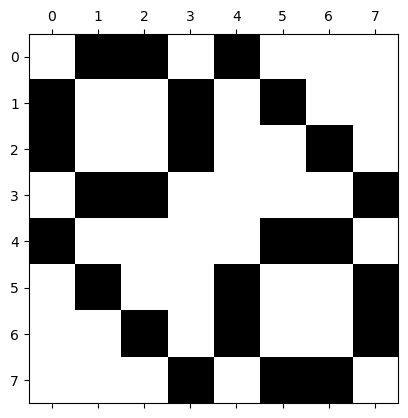

In [16]:

m = generate_sparse_matrix(1)

# print(m)
show_array(m.toarray(), "")


In [17]:
def asymmetrical_elimination(M):
    G = Graph(M)
    for k in range(M.shape[0]):
        succ = {e[1] for e in G.E if e[0] == k}
        pred = {e[0] for e in G.E if e[1] == k}
        G.V = G.V.difference({k})
        G.E = G.E.difference({e for e in G.E if e[1] in succ})
        G.E = G.E.difference({e for e in G.E if e[0] in pred})
        G.E.update({(x, y) for x in pred for y in succ})

In [18]:
def minimum_degree_permutation(matrix):
    G = Graph(matrix)
    return G.elimination_ordering()
    # permutation = []
    # while G.V:
    #     v_min = G.get_min_degree_vertex()
    #     G.V.remove(v_min)
    #     for u in G.get_neighbors(v_min):
    #         G.E.remove((v_min, u))
    #     permutation.append(v_min)
    # return permutation

def cuthill_mckee(matrix):
    G = Graph(matrix)
    return G.cuthill_mckee()
    # def BFS(G, start, visited, permutation):
    #     Q = deque()
    #     Q.append(start)
    #     while Q:
    #         v = Q.popleft()
    #         if visited[v]:
    #             continue
    #         permutation.append(v)
    #         visited[v] = True
    #         for u in sorted(G.get_neighbors(v), key=lambda x: len(G.get_neighbors(x))):
    #             if not visited[u]:
    #                 Q.append(u)
    #
    # G = Graph(matrix)
    # permutation = []
    # visited = [False for _ in range(len(matrix))]
    # sorted_nodes = sorted([x for x in G.V], key=lambda x: len(G.get_neighbors(x)))
    #
    # for s in sorted_nodes:
    #     if not visited[s]:
    #         BFS(G, s, visited, permutation)
    #
    # return permutation

def reverse_cuthill_mckee(matrix):
    G = Graph(matrix)
    return G.reverse_cuthill_mckee()

def permutate(matrix, permutation_function):
    permutation = permutation_function(matrix)
    new_matrix = matrix.copy()

    for i in range(len(permutation)):
        if i == permutation[i]:
            continue
        new_matrix[i, :] = matrix[permutation[i], :].copy()

    matrix = new_matrix.copy()

    for i in range(len(permutation)):
        if i == permutation[i]:
            continue
        new_matrix[:, i] = matrix[:, permutation[i]].copy()

    return new_matrix

In [19]:
def show_sparsity_patterns():
    cutoff = 2/3
    data = {
        'k': [],
        'compression ratio': [],
        'compressed': [],
        'type': []
    }
    df = pd.DataFrame(data)
    for k in [2, 3, 4]:
        # Before Compression
        M = generate_sparse_matrix(k).toarray()
        print(f"Generated Matrix {k}")
        v = not_compressed_tree(M)
        original_zeros_count = sum_sizes_rank_zero(v)
        df = df._append({'k': k, 'compression ratio': (1-original_zeros_count)/(1-original_zeros_count),
                        'compressed': 0, 'type': 'no_permutation'}, ignore_index=True)

        minim = permutate(M, minimum_degree_permutation)
        print(f"Permuted Matrix Minim {k}")
        v = not_compressed_tree(minim)
        zeros_count = sum_sizes_rank_zero(v)
        df = df._append({'k': k, 'compression ratio': (1-original_zeros_count)/(1-zeros_count),
                        'compressed': 0, 'type': 'minimum_degree_permutation'}, ignore_index=True)

        cuthill = permutate(M, cuthill_mckee)
        print(f"Permuted Matrix cuthill {k}")
        v = not_compressed_tree(cuthill)
        zeros_count = sum_sizes_rank_zero(v)
        df = df._append({'k': k, 'compression ratio': (1-original_zeros_count)/(1-zeros_count),
                        'compressed': 0, 'type': 'cuthill_mckee'}, ignore_index=True)

        rev_cuthill = permutate(M, reverse_cuthill_mckee)
        print(f"Permuted Matrix rev_cuthill {k}")
        v = not_compressed_tree(rev_cuthill)
        zeros_count = sum_sizes_rank_zero(v)
        df = df._append({'k': k, 'compression ratio': (1-original_zeros_count)/(1-zeros_count),
                        'compressed': 0, 'type': 'reverse_cuthill_mckee'}, ignore_index=True)
        if k == 4:
            show_array(csr_matrix(M), f"Before permutation: k = {k}")
            show_array(csr_matrix(minim), f"Minimum degree permutation: k = {k}")
            show_array(csr_matrix(cuthill), f"Cuthill-McKee permutation: k = {k}")
            show_array(csr_matrix(rev_cuthill), f"Reverse Cuthill-McKee permutation: k = {k}")
        else:
            show_array(M, f"Before permutation: k = {k}")
            show_array(minim, f"Minimum degree permutation  k = {k}")
            show_array(cuthill, f"Cuthill-McKee permutation: k = {k}")
            show_array(rev_cuthill, f"Reverse Cuthill-McKee permutation: k = {k}")

        # After Compression
        U, s, V = np.linalg.svd(M)
        plt.plot(s)
        plt.axvline(x=int(cutoff * len(s)), color='red', linestyle='--', label=f's[{int(cutoff * len(s))}]')
        plt.title(f"Singular values for k = {k}")
        plt.savefig("plots/"+f"Singular values for k = {k}".replace(" ", "_").replace(" = ", "-").replace("=", "-").replace(":", "")+".png")
        plt.show()
        M_v = create_tree(M, 4, s[int(cutoff * len(s))])
        print(f"Compressed Matrix {k}")
        M_v_m = recover_matrix(M_v)
        zeros_count = sum_sizes_rank_zero(M_v)
        df = df._append({'k': k, 'compression ratio': (1-original_zeros_count)/(1-zeros_count),
                        'compressed': 1, 'type': 'no_permutation'}, ignore_index=True)

        minim_v = create_tree(minim, 4, s[int(cutoff * len(s))])
        print(f"Compressed Matrix Minim {k}")
        minim_v_m = recover_matrix(minim_v)
        zeros_count = sum_sizes_rank_zero(minim_v)
        df = df._append({'k': k, 'compression ratio': (1-original_zeros_count)/(1-zeros_count),
                        'compressed': 1, 'type': 'minimum_degree_permutation'}, ignore_index=True)

        cuthill_v = create_tree(cuthill, 4, s[int(cutoff * len(s))])
        print(f"Compressed Matrix cuthill {k}")
        cuthill_v_m = recover_matrix(cuthill_v)
        zeros_count = sum_sizes_rank_zero(cuthill_v)
        df = df._append({'k': k, 'compression ratio': (1-original_zeros_count)/(1-zeros_count),
                        'compressed': 1, 'type': 'cuthill_mckee'}, ignore_index=True)

        rev_cuthill_v = create_tree(rev_cuthill, 4, s[int(cutoff * len(s))])
        print(f"Compressed Matrix rev_cuthill{k}")
        rev_cuthill_v_m = recover_matrix(rev_cuthill_v)
        zeros_count = sum_sizes_rank_zero(rev_cuthill_v)
        df = df._append({'k': k, 'compression ratio': (1-original_zeros_count)/(1-zeros_count),
                        'compressed': 1, 'type': 'reverse_cuthill_mckee'}, ignore_index=True)
        if k == 4:
            show_array(csr_matrix(M_v_m), f"Before permutation matrix after compression: k = {k}")
            show_array(csr_matrix(minim_v_m), f"Minimum degree permutation after compression: k = {k}")
            show_array(csr_matrix(cuthill_v_m), f"Cuthill-McKee permutation after compression: k = {k}")
            show_array(csr_matrix(rev_cuthill_v_m), f"Reverse Cuthill-McKee permutation after compression: k = {k}")
        else:
            show_array(M_v_m, f"Before permutation matrix after compression: k = {k}")
            show_array(minim_v_m, f"Minimum degree permutation after compression: k = {k}")
            show_array(cuthill_v_m, f"Cuthill-McKee permutation after compression: k = {k}")
            show_array(rev_cuthill_v_m, f"Reverse Cuthill-McKee permutation after compression: k = {k}")
    return df




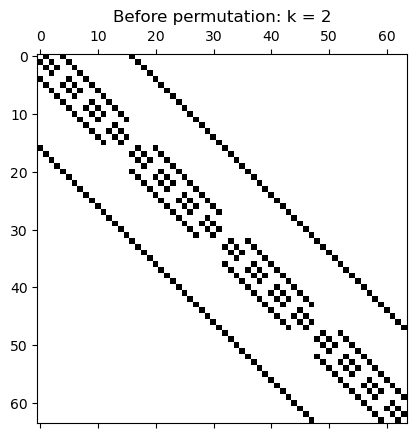

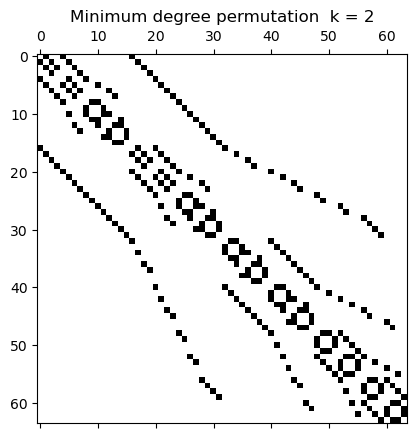

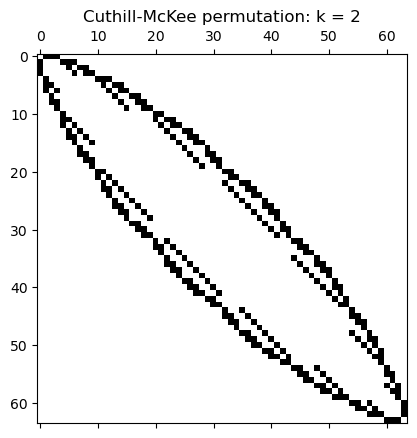

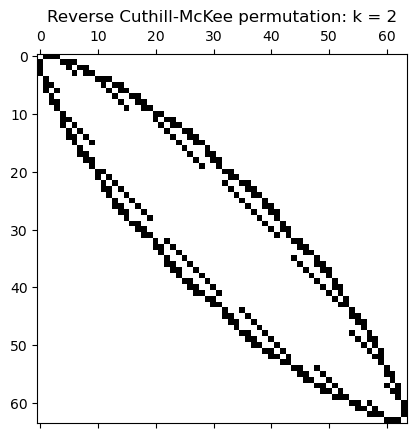

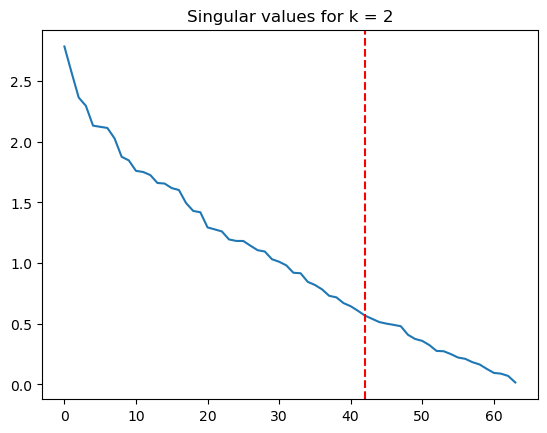

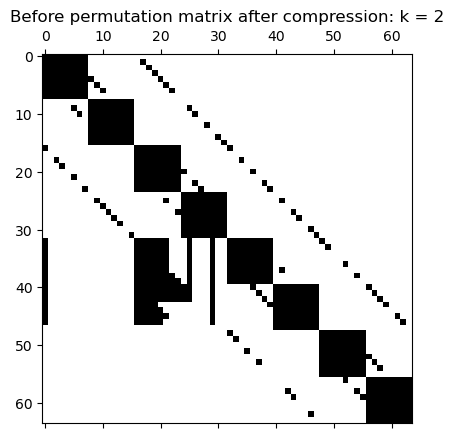

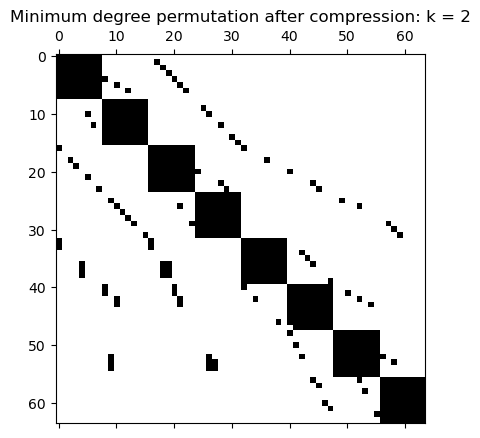

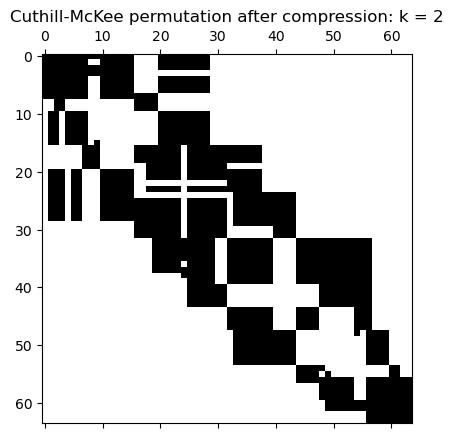

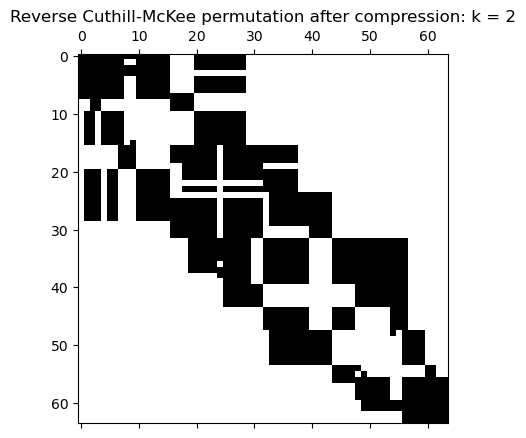

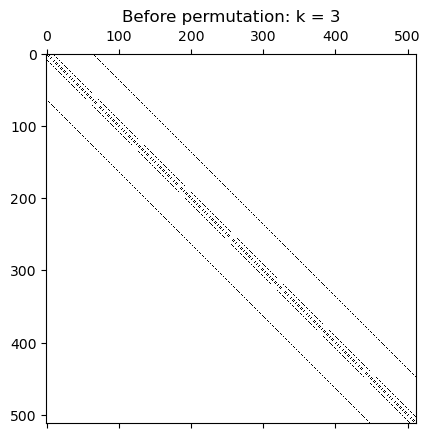

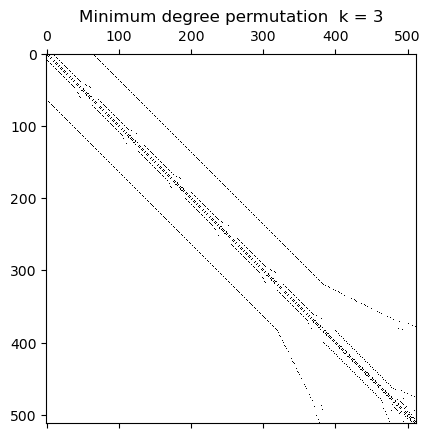

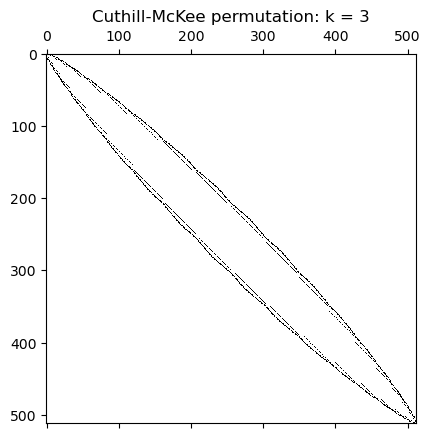

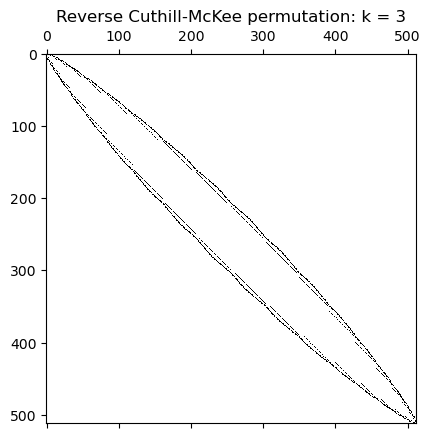

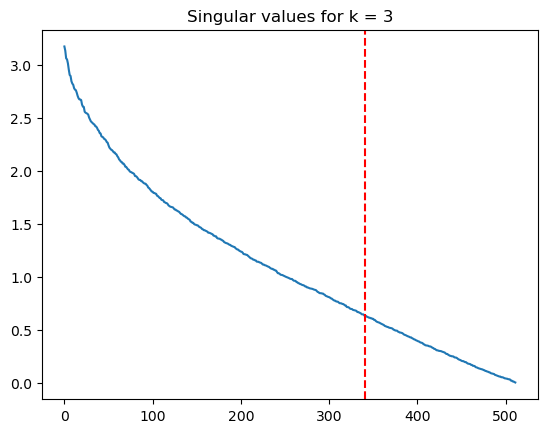

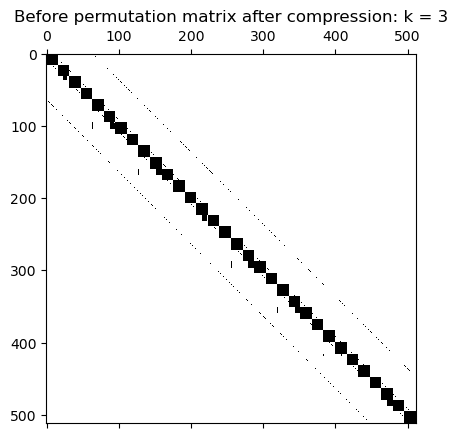

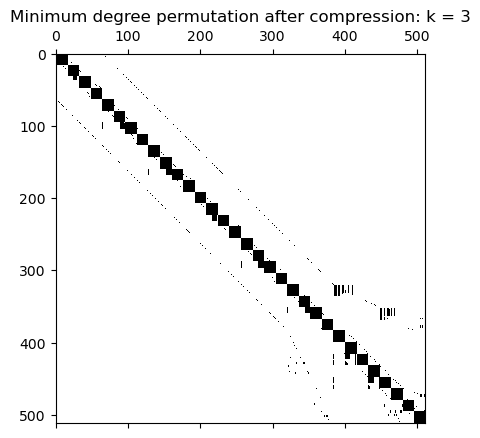

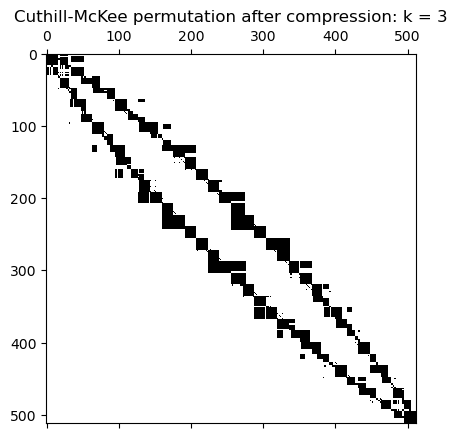

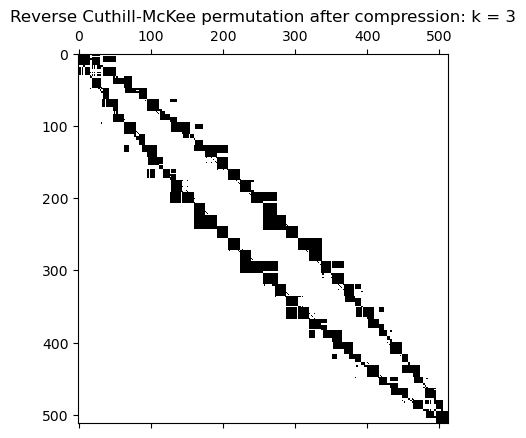

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\szynt\.conda\envs\PSI\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\szynt\AppData\Local\Temp\ipykernel_11356\2312789603.py", line 1, in <module>
    df = show_sparsity_patterns()
  File "C:\Users\szynt\AppData\Local\Temp\ipykernel_11356\566161816.py", line 18, in show_sparsity_patterns
    minim = permutate(M, minimum_degree_permutation)
  File "C:\Users\szynt\AppData\Local\Temp\ipykernel_11356\1636901932.py", line 45, in permutate
    permutation = permutation_function(matrix)
  File "C:\Users\szynt\AppData\Local\Temp\ipykernel_11356\1636901932.py", line 3, in minimum_degree_permutation
    return G.elimination_ordering()
  File "C:\Users\szynt\AppData\Local\Temp\ipykernel_11356\4024693618.py", line 45, in elimination_ordering
    p = self.get_min_degree_vertex()
  File "C:\Users\szynt\AppData\Local\Temp\ipykernel_11356\4024693618.py"

In [20]:
df = show_sparsity_patterns()
df.to_csv("df_compression_ratio.csv", index=True)

In [ ]:
def generate_bar_plot(df):
    unique_k_values = df['k'].unique()

    # Define colors for bars
    colors = plt.cm.tab20(np.linspace(0, 1, len(df)))

    for k_value in unique_k_values:
        subset = df[(df['k'] == k_value)]
        x_labels = subset['type'].tolist()

        plt.figure(figsize=(10, 6))

        # Plot each bar with a different color
        for i, label in enumerate(x_labels):
            plt.bar(i, subset.iloc[i]['compression ratio'], color=colors[i], label=label)

        plt.xlabel('Type')
        plt.ylabel('Compression Ratio')
        plt.title(f"Compression Ratio for k={k_value}")
        plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45)  # Rotate x-axis labels by 45 degrees
        # plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
        plt.tight_layout()
        plt.show()
df = pd.read_csv("df_compression_ratio.csv", index_col=0)
generate_bar_plot(df)